# Проект: "Стоимость автомобиля"

## Описание проекта

__Задача:__ 

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении имеются исторические данные по техническим характеристикам, комплектации и ценам автомобилей.  

Нужно построить модель для определения стоимости. Заказчику важны: 
- качество предсказания;  
- скорость предсказания;  
- время обучения.  

Для оценки качества моделей используется метрику _RMSE_. Её значение должно быть меньше 2500.

__Основные шаги:__  
- Загрузка и изучение данных;
- Предобработка данных и создание выборок;
- Обучение нескольких моделей машинного обучения, как использующие бустинг, так и не использующие его;
- Сравнение моделей мо скорости и качеству обучения;
- Выбор лучшей модели в соответствии с заявленными требованиями.

__Описание данных:__  
_Предсказательные признаки:_  
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя


_Целевой признак:_  
- `Price` — цена (евро)

## Подготовка данных

- Загрузиим данные, путь к файлу: `/datasets/autos.csv`.
- Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Удалим неинформативные признаки.
- Подготовим выборки для обучения моделей.

### Загрузка данных

In [1]:
# проверка наличия библиотек
try:
    import category_encoders
    print('Category Encoders ver.:', category_encoders.__version__)
except:
    !pip install category_encoders

Category Encoders ver.: 2.6.0


In [2]:
# проверка наличия библиотек
try:
    import optuna
    print('Optuna ver.:', optuna.__version__)
except:
    !pip install optuna

Optuna ver.: 3.1.0


In [3]:
# проверка наличия библиотек
try:
    import lightgbm as lgbm
    print('LightGBM ver.:', lgbm.__version__)
except:
    !pip install lightgbm

LightGBM ver.: 3.3.5


In [4]:
# импорт библиотек
import pandas as pd
import numpy as np
import phik

from lightgbm import LGBMRegressor

from optuna.integration import OptunaSearchCV
from category_encoders.target_encoder import TargetEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.dummy import DummyRegressor


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

In [5]:
# чтение файла данных из папки по умолчанию и из рабочей директории
try:
    data = pd.read_csv('/datasets/autos.csv', sep=',')
except:
    data = pd.read_csv('autos.csv', sep=',')

In [6]:
# пример данных
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Исследовательский анализ данных

In [7]:
# тип данных и возможные пропуски
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
# определение процента пропусков
print('Доля пропусков в признаках, %:')
(data.isna().mean()*100).round(1)

Доля пропусков в признаках, %:


DateCrawled           0.0
Price                 0.0
VehicleType          10.6
RegistrationYear      0.0
Gearbox               5.6
Power                 0.0
Model                 5.6
Kilometer             0.0
RegistrationMonth     0.0
FuelType              9.3
Brand                 0.0
Repaired             20.1
DateCreated           0.0
NumberOfPictures      0.0
PostalCode            0.0
LastSeen              0.0
dtype: float64

In [9]:
# статистика по данным всех типов
data.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


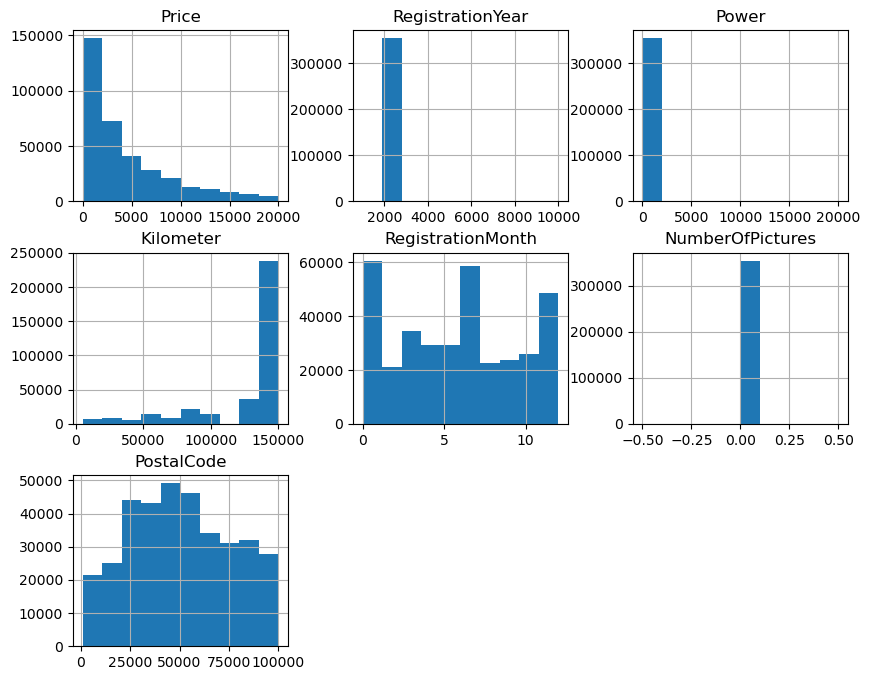

In [10]:
# гистограммы распределений значений в признаках
data.hist(figsize=[10, 8]);

In [11]:
# определение числа уникальных значений
print('Число уникальных значений в признаках:')
data.nunique()

Число уникальных значений в признаках:


DateCrawled          271174
Price                  3731
VehicleType               8
RegistrationYear        151
Gearbox                   2
Power                   712
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
Repaired                  2
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64

Данные нуждаются в существенной предобработке. В них содержится значительное количество пропусков, аномальных значений. В числовых признаках встречаются "заглушки". Признаки включают в свой состав неинформативные, некоторые требуют смены типа значений. Для использования в машинном обучении также необходимо кодировать категориальные признаки и провести масштабирование числовых. Дополнительным неудобством является наличие большое количество уникальных значений в некоторых категориальных признаках. Возможно, для них стоит предусмотреть более рациональный способ кодирование, нежели привычное унитарное кодирование.

### Предобработка данных

In [12]:
# копия данных
df = data.copy()

#### Удаление дубликатов

In [13]:
# оценка числа и удаление дубликатов
print('Количество дубликатов в данных:', df.duplicated().sum())
df.drop_duplicates(inplace=True)


Количество дубликатов в данных: 4


#### Заполнение пропусков

In [14]:
# список значений с пропусками
na_columns = df.isna().sum()[df.isna().sum().values > 0].index.tolist()

In [15]:
# признаки с пропусками
df[na_columns].head()

,VehicleType,Gearbox,Model,FuelType,Repaired
0,NaN,manual,golf,petrol,NaN
1,coupe,manual,NaN,gasoline,yes
2,suv,auto,grand,gasoline,NaN
3,small,manual,golf,petrol,no
4,small,manual,fabia,gasoline,no


Начнем с обработки пропусков в категориальных данных. Все они относятся к категориальным данным.  Процент пропущенных значений в них достаточно значителен - от 5 до 20%. Наиболее рациональным способом решения проблемы пропусков будет выделение под них отдельной категории в каждом из признаков. 

In [16]:
# список признаков с малым числом категорий
na_columns_copy = na_columns.copy()
na_columns_copy.remove('Model')
# уникальные значения признаков с пропусками
for col in na_columns_copy:
    print(col, df.drop(['Model'], axis=1)[col].unique())

VehicleType [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox ['manual' 'auto' nan]
FuelType ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
Repaired [nan 'yes' 'no']


In [17]:
# проверка наличия класса other
print('Наличие класса "other" в признаке "Model":', 'other' in df['Model'].values)

Наличие класса "other" в признаке "Model": True


Ряд признаков уже содержит неопределенную категорию - `other`. Ею и заполним пропуски в категориальных признаках.

In [18]:
# заполнение пропусков
df.fillna('other', inplace=True)

#### Обработка аномальных значений

Ряд признаков содержат аномальные значения. В частности, они имеются в годе и месяце регистрации. В признаке `RegistrationYear` их не много и их можно удалить, в признаке `RegistrationMonth` большое количество нулевых значений - заменим их медианой.  
В признаке мощности двигателя `Power` встречаются очевидно завышенные значения - ограничим их каким-то разумным пределом, свойственным популярным автомобилям. Также признак имеет большое количество нулевых значений. Заменим их медианой, но добавим дополнительный признак, указывающий на отсутствие указания мощности.
Среди целевого признака цены авто `Price` встречается большое количество нулевых значений. Заменить их чем-либо не представляется возможным.   
В признаке почтовых индексов `PostalCode` подавляющее большинство значений не соответствует принятому в России стандарту (почтовый индекс - это шестизначное число, причем начальное число ограничено диапазоном от 1 до 6 и исключает 5). Оценить наличие аномалий в этом признаке очень сложно.

In [19]:
# оценка аномалий в годе регистрация
print('Число аномальных значений в признаке "RegistrationYear":',
      len(df[(df['RegistrationYear'] > 2023) | (df['RegistrationYear'] < 1900)])
     )

Число аномальных значений в признаке "RegistrationYear": 171


In [20]:
# удалений аномалий в признаках даты регистрации
df = df[~(df['RegistrationYear'] > 2023) & ~(df['RegistrationYear'] < 1900)]
df['RegistrationMonth'].replace(0, df['RegistrationMonth'].median(), inplace=True)

In [21]:
# оценка и удаление аномалий в мощности двигателя
print('Число аномально высоких значений в признаке "Power":', len(df[df['Power'] > 500]))
df = df[df['Power'] < 500]

Число аномально высоких значений в признаке "Power": 448


In [22]:
# фиксация отсутствия мощности двигателя
df['BePowered'] = 1
# фиксируется также аномально низкая мощность двигателя
df['BePowered'].mask(df['Power'] < 5, 0, inplace=True)
# замена аномально-малых значений мощности медианой
df['Power'].mask(df['Power'] < 5, df['Power'].median(), inplace=True)

In [23]:
# удалений аномалий в признаке цены
df = df[df['Price'] > 100]

#### Изменение пространства признаков

Признак `NumberOfPictures` содержит большое число нулей. Оценим его информативность и при необходимости удалим.

In [24]:
# оценка числа уникальных значений признака NumberOfPictures
print('Число ненулевых значений в признаке "NumberOfPictures":', data['NumberOfPictures'].sum())
# удаление признака NumberOfPictures
df.drop(['NumberOfPictures'], axis=1, inplace=True)

Число ненулевых значений в признаке "NumberOfPictures": 0


Признак `DateCrawled` - дата скачивания анкеты из базы - не имеет ценности для анализа и его стоит удалить. Вместо `DateCreated` и `LastSeen` - дат создания анкеты и последней активности пользователя - имеет смысл ввести разницу между этими датами, так продолжительность продажи автомобиля отражается на его цене.  
В признаковом пространстве присутствует признак `RegistrationMonth` - месяц регистрации автомобиля. Сам по себе этот признак неинформативен, но можно ввести дополнительный признак о длительности состояния "зарегистрированности" на момент начало продажи на основе года `RegistrationYear` и месяца регистрации `RegistrationMonth`, а также даты создания анкеты `DateCreated`.

In [25]:
# временный датасет для создания новых признаков
df_temp = df[['RegistrationYear', 'RegistrationMonth']].copy()
# формирования набора для создания даты регистрации
df_temp.columns = ['year', 'month']
df_temp['day'] = 1
df_temp['RegistrationDate'] = pd.to_datetime(df_temp)

# копия признаков с датами активности пользователя
df_temp['DateCreated'] = df['DateCreated'].astype('datetime64[ns]')
df_temp['LastSeen'] = df['LastSeen'].astype('datetime64[ns]')

# число месяцев с момента регистрации
df_temp['RegistratedMonths'] = ((df_temp['DateCreated'] - df_temp['RegistrationDate']) / np.timedelta64 (1, 'M')).round()
# число недель активности пользователя
df_temp['ActivityWeeks'] = ((df_temp['LastSeen'] - df_temp['DateCreated']) / np.timedelta64 (1, 'W')).round()

In [26]:
# удаление неинформативных признаков
df.drop(['DateCrawled', 'RegistrationYear', 'RegistrationMonth', 'DateCreated', 'LastSeen'], axis=1, inplace=True)
# добавление новых признаков
df = df.join(df_temp[['RegistratedMonths','ActivityWeeks']])

Изменим некоторые типов данных с целочисленного на действительный. Это касается признаков: `Price`, `Power` и `Kilometer`.  

In [27]:
# заменна типа признака на float
df['Price'] = df['Price'].astype('float64')
df['Power'] = df['Power'].astype('float64')
df['Kilometer'] = df['Kilometer'].astype('float64')
df

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode,BePowered,RegistratedMonths,ActivityWeeks
0,480.0,other,manual,105.0,golf,150000.0,petrol,volkswagen,other,70435,0,274.0,2.0
1,18300.0,coupe,manual,190.0,other,125000.0,gasoline,audi,yes,66954,1,59.0,2.0
2,9800.0,suv,auto,163.0,grand,125000.0,gasoline,jeep,other,90480,1,139.0,3.0
3,1500.0,small,manual,75.0,golf,150000.0,petrol,volkswagen,no,91074,1,178.0,0.0
4,3600.0,small,manual,69.0,fabia,90000.0,gasoline,skoda,no,60437,1,93.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,1150.0,bus,manual,105.0,zafira,150000.0,petrol,opel,no,26624,0,193.0,0.0
354365,2200.0,other,other,105.0,other,20000.0,other,sonstige_autos,other,39576,0,134.0,3.0
354366,1199.0,convertible,auto,101.0,fortwo,125000.0,petrol,smart,no,26135,1,192.0,1.0
354367,9200.0,bus,manual,102.0,transporter,150000.0,gasoline,volkswagen,no,87439,1,241.0,3.0


#### Кодирование признаков

Среди дискретных признаков признаков, которые можно отнести категориальным есть признак `PostalCode`, имеющий очень большое количество уникальных значений. При применении к нему _one-hot_-кодирования пространство признаков увеличиться на несколько тысяч. Вероятно имеет смысл применить к нему другой тип кодирования, например, - частотное. 
В признаке встречаются два типа почтовых индексов 4-х и 5-ти значные. Можно добавить признак, который бы учитывал эти категории, также можно разбить коды на отдельные зоны и сформировать из них категории для последующего кодирования.

In [28]:
# проверка числа символов в почтовом индексе
df['PostalCode'].astype('str').apply(lambda x: len(x)).unique()

array([5, 4], dtype=int64)

In [29]:
# # частотное кодирование признака
# df['PostalCodeFreq'] = df['PostalCode'].map(df.groupby('PostalCode').size() / len(df))

# # бинарный признак по длине почтового индекса
# df['PostalCodeLen'] = df['PostalCode'].astype('str').apply(lambda x: len(x)) - 4
# # признак почтовой зоны
# df['PostalCodeArea'] = df['PostalCode'].copy()
# df['PostalCodeArea'] = df['PostalCodeArea'].mask(df['PostalCodeLen'] == 0, df['PostalCodeArea'] // 1000)
# df['PostalCodeArea'] = df['PostalCodeArea'].mask(df['PostalCodeLen'] == 1, (df['PostalCodeArea'] // 10000)*10)
# df.drop(['PostalCode', 'PostalCodeLen'], axis=1, inplace=True)

Признак марки автомобиля `Model` хотя и содержит значительное количество уникальных значений, но их всё же не так много, как в `PostalCode`. Для уменьшения признакового пространство его тоже можно попробовать кодировать - например, средней ценой в категории.

In [30]:
# # кодирование средней ценой
# df['Model'] = df['Model'].map(df.groupby('Model')['Price'].mean())

Посмотрим какие ещё варианты кодирования существуют. Значительным набором кодировщиком располагает библиотека _Category Encoders_. Часть из них - типа _Target-based Coding_ использует сведения о разметке (цели) датасета и склонна к переобучению, другая - типа _Contrast Coding_ разбивает признак на уровни и подходит, по большей части, только для упорядоченных или частично упорядоченных признаков. 
Использование кодировщиков первого типа ведёт к неизбежной потери качества прогноза, но не раздувает признакового пространства.
К таковым относятся: `GLMMEncoder`, `TargetEncoder`, `JamesSteinEncoder`, `CatBoostEncoder`, `MEstimateEncoder`. Они показывают схожее качество при прогнозировании.
Существуют приёмы повышения их качества. Вот [пример](https://towardsdatascience.com/benchmarking-categorical-encoders-9c322bd77ee8). Но так как, одним из ограничений модели является скорость её обучения-прогноза, использовать подобные техники мы не будем. 
Выберем один из кодировщиков библиотеки _Category Encoders_ - `TargetEncoder` и используем его для кодирования всех категориальных признаков.

In [31]:
# выделение действительных признаков
num_cols = df.drop('Price', axis=1).select_dtypes(include=['float64']).columns.tolist()
# выделение строковых и дискретных признаков
cat_cols = df.drop('Price', axis=1).select_dtypes(exclude=['float64']).columns.tolist()
cat_cols

['VehicleType',
 'Gearbox',
 'Model',
 'FuelType',
 'Brand',
 'Repaired',
 'PostalCode',
 'BePowered']

После кодирования категориальных признаков все признаки становятся числовыми. Однако, мы будем применять привычное масштабирование с помощью `StandardScaler` только к изначально числовым, чтобы дополнительно не искажать данные. Кроме того, размер значений кодированных признаков не сильно отличается от нормализованных. Фактически, масштабирование нужно для равномерной скорости обучения различных признаков, что гарантирует достижение минимума функции потерь. Отсутствие масштабирования необязательно сказывается на качестве прогноза.

In [32]:
# кодирование категориальных признаков с последующей стандартизацией
preprocessing = ColumnTransformer(transformers=[('num', StandardScaler(), num_cols), ('cat', TargetEncoder(), cat_cols)])

#### Проблема мультиколлинеарности

In [33]:
# корреляция числовых и категориальных признаков
df.phik_matrix().style.background_gradient(cmap='PuBu')

interval columns not set, guessing: ['Price', 'Power', 'Kilometer', 'PostalCode', 'BePowered', 'RegistratedMonths', 'ActivityWeeks']


,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode,BePowered,RegistratedMonths,ActivityWeeks
Price,1.000000,0.282190,0.299521,0.494445,0.576424,0.314386,0.270517,0.362233,0.348914,0.092107,0.227959,0.507897,0.007847
VehicleType,0.282190,1.000000,0.342916,0.431516,0.900442,0.173371,0.413331,0.617946,0.306296,0.068252,0.352783,0.315534,0.007677
Gearbox,0.299521,0.342916,1.000000,0.467905,0.616653,0.055998,0.288353,0.511648,0.434521,0.087365,0.238002,0.106647,0.017331
Power,0.494445,0.431516,0.467905,1.000000,0.757658,0.091965,0.232152,0.544424,0.140683,0.075045,0.487618,0.206844,0.000000
Model,0.576424,0.900442,0.616653,0.757658,1.000000,0.436778,0.532496,0.997824,0.256172,0.215173,0.182126,0.544667,0.060826
Kilometer,0.314386,0.173371,0.055998,0.091965,0.436778,1.000000,0.152833,0.274361,0.227289,0.038828,0.066500,0.327290,0.008047
FuelType,0.270517,0.413331,0.288353,0.232152,0.532496,0.152833,1.000000,0.285733,0.232625,0.053879,0.190109,0.197399,0.000000
Brand,0.362233,0.617946,0.511648,0.544424,0.997824,0.274361,0.285733,1.000000,0.145989,0.179494,0.128644,0.347057,0.034721
Repaired,0.348914,0.306296,0.434521,0.140683,0.256172,0.227289,0.232625,0.145989,1.000000,0.062164,0.168251,0.148783,0.009021
PostalCode,0.092107,0.068252,0.087365,0.075045,0.215173,0.038828,0.053879,0.179494,0.062164,1.000000,0.078015,0.055309,0.004585


Оценка степени корреляции признаков выполнялась на основе коэффициента _Phik (𝜙k)_, так как привычный коэффициент Пирсона не позволяет оценивать категориальные признаки. 
Изначально признак `Model` был сильно коррелирован и с признаком `Brand` и с признаком `VehicleType` и являлся очевидным кандидатом на удаление, но его связь с целевым не настолько сильна, чтобы подозревать наличие мультиколлинеарности.  

__Замечание:__ Картина корреляции отражаете состояние до кодирования категориальных признаков ⚠.

#### Создание выборок 

In [34]:
# создание выборок
features_train, features_test, target_train, target_test = train_test_split(
    df.drop('Price', axis=1), df['Price'], test_size=0.2, random_state=42
)

## Обучение моделей

Обучим несколько моделей, с бустингом и без. Для каждой модели попробуем разные гиперпараметры.

In [35]:
# # выделение действительных признаков
# num_cols = features_train.select_dtypes(include=['float64']).columns.tolist()
# # признаки, которые можно отнести к категориальным
# cat_cols = features_train.select_dtypes(exclude=['float64']).columns.tolist()

# # раздельное кодирование признаков и последующим объединением в плотную матрицу
# preprocessing = ColumnTransformer(
#     [('num', StandardScaler(), num_cols), ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_cols)]
# )

При подборе гиперпараметров мы ограничены двумя взаимоисключающими условиями: высокое качество прогноза при высокой скорости обучения. Как наиболее перспективные мы рассматриваем алгоритмы на решающих деревьях и вынуждены ограничить число эстиматоров (в пределах 300), так этот показатель в наибольшей степени влияет на скорость обучения. Чтобы избежать переобучения, также стоит ограничить глубину деревьев.  
Сначала запустим каждый рассматриваемых алгоритмов на настройках по умолчанию, и оценим возможность дообучения моделей.

### LGBMRegressor

In [36]:
# cv для LGBMRegressor с базовыми настройками
lgbmr_cv = GridSearchCV(estimator=Pipeline(steps=[('prep', preprocessing), ('reg', LGBMRegressor(random_state=42))]),
                         param_grid={},
                         scoring='neg_root_mean_squared_error',
                         n_jobs=-1
                        )
lgbmr_cv.fit(X=features_train, y=target_train)
print('Точность прогноза для LGBMRegressor по RSME с настройками по умолчанию равна %.1f.' %(- lgbmr_cv.best_score_))

Точность прогноза для LGBMRegressor по RSME с настройками по умолчанию равна 1694.6.


In [37]:
# # подбор гиперпараметров для LGBMRegressor
# pipe = Pipeline(steps=[('prep', preprocessing), ('reg', LGBMRegressor(random_state=42))])
# param_dist = {
#               'reg__boosting_type':optuna.distributions.CategoricalDistribution(['gbdt', 'dart', 'goss']),
#               'reg__learning_rate': optuna.distributions.FloatDistribution(0.1, 0.5, 0.05),
#               'reg__n_estimators': optuna.distributions.IntDistribution(100, 300, 30),
#               'reg__num_leaves': optuna.distributions.IntDistribution(10, 200, 15),
#               'reg__max_depth': optuna.distributions.IntDistribution(6, 20, 2),
#               'reg__subsample_for_bin': optuna.distributions.IntDistribution(1000, 200000, 1000),
#               'reg__min_child_samples': optuna.distributions.IntDistribution(100, 500, 50),
#               'reg__random_state': optuna.distributions.IntDistribution(1, 1000, 1),
#               'reg__colsample_bytree': optuna.distributions.FloatDistribution(0.2, 1, 0.1)
#              }
# search_cv = OptunaSearchCV(estimator=pipe,
#                            param_distributions=param_dist,
#                            scoring='neg_root_mean_squared_error',
#                            verbose=-1,
#                            n_jobs=-1,
#                            n_trials=100,
#                            cv=3,
#                            random_state=42
#                           )
# search_cv.fit(X=features_train, y=target_train)
# print(- search_cv.best_score_, search_cv.best_estimator_)

Набор гиперпараметров для `LGBMRegressor`, найденных с помощью оптимизатора _Optuna_:  
~~~
colsample_bytree=0.5884359396877478,
learning_rate=0.15120957379246172,
max_depth=17,
min_child_samples=100,
n_estimators=238,
num_leaves=200,
random_state=549,
subsample_for_bin=2985
~~~
Точность прогноза по _RSME_ для найденных параметров составила 1560.169.

### ElasticNet

In [38]:
# cv для ElasticNet с базовыми настройками
elnt_cv = GridSearchCV(estimator=Pipeline(steps=[('prep', preprocessing), ('reg', ElasticNet(random_state=42))]),
                         param_grid={},
                         scoring='neg_root_mean_squared_error',
                         n_jobs=-1
                        )
elnt_cv.fit(X=features_train, y=target_train)
print('Точность прогноза для ElasticNet по RSME с настройками по умолчанию равна %.3f.' %(- elnt_cv.best_score_))

Точность прогноза для ElasticNet по RSME с настройками по умолчанию равна 2898.976.


In [39]:
# # подбор гиперпараметров для ElasticNet
# pipe = Pipeline(steps=[('prep', preprocessing), ('reg', ElasticNet(random_state=42))])
# param_dist = {
#     'reg__alpha': optuna.distributions.FloatDistribution(0.1, 1, 0.1),
#     'reg__l1_ratio': optuna.distributions.FloatDistribution(0.1, 1, 0.1),
#     'reg__tol': optuna.distributions.FloatDistribution(0.00001, 0.001, 0.00005)
# }
# search_cv = OptunaSearchCV(estimator=pipe,
#                            param_distributions=param_dist,
#                            scoring='neg_root_mean_squared_error',
#                            n_jobs=-1,
#                            cv=3,
#                            random_state=42
#                         )
# search_cv.fit(X=features_train, y=target_train)
# print(- search_cv.best_score_, search_cv.best_estimator_)

Набор гиперпараметров для `ElasticNet`, найденных с помощью оптимизатора _Optuna_:  
~~~
alpha=0.5038106785837163,
l1_ratio=0.8598335466493537,
random_state=42,
tol=0.0001721991337483358
~~~  
Точность прогноза по _RSME_ для найденных параметров составила 2796.605.

### RandomForestRegressor

In [40]:
# # cv для LinearSVR с базовыми настройками
# rfr_cv = GridSearchCV(estimator=Pipeline(steps=[('prep', preprocessing), ('reg', RandomForestRegressor(random_state=42))]),
#                          param_grid={},
#                          scoring='neg_root_mean_squared_error',
#                          n_jobs=-1
#                         )
# rfr_cv.fit(X=features_train, y=target_train)
# print('Точность прогноза для RandomForestRegressor по RSME с настройками по умолчанию равна %.3f.' %(- rfr_cv.best_score_))

In [41]:
# # подбор гиперпараметров для RandomForestRegressor
# pipe = Pipeline(steps=[('prep', preprocessing), ('reg', RandomForestRegressor(random_state=42))])
# param_dist = {
#     'reg__n_estimators': optuna.distributions.IntDistribution(50, 300, 30),
#     'reg__max_depth': optuna.distributions.IntDistribution(4, 20, 2),    
#     'reg__min_samples_split': optuna.distributions.IntDistribution(2, 10, 2),
#     'reg__min_samples_leaf': optuna.distributions.IntDistribution(1, 10, 2),
#     'reg__min_impurity_decrease': optuna.distributions.FloatDistribution(0.1, 1, 0.1),
#     'reg__ccp_alpha': optuna.distributions.FloatDistribution(0.1, 1, 0.1)
# }
# search_cv = OptunaSearchCV(estimator=pipe,
#                            param_distributions=param_dist,
#                            scoring='neg_root_mean_squared_error',
#                            n_jobs=-1,
#                            cv=3,
#                            random_state=42
#                         )
# search_cv.fit(X=features_train, y=target_train)
# print(- search_cv.best_score_, search_cv.best_estimator_)

Набор гиперпараметров для `RandomForestRegressor`, найденных с помощью оптимизатора _Optuna_:  
~~~
ccp_alpha=0.3979111741800548,
max_depth=20,
min_impurity_decrease=0.3703796916540737,
min_samples_split=10, 
n_estimators=125,
random_state=42
~~~  
Точность прогноза по _RSME_ для найденных параметров составила 1607.985. Модель `RandomForestRegressor` склонна к переобучению и часто обучается на всю доступную глубину дерева.

### KNeighborsRegressor

In [42]:
# cv для KNeighborsRegressor с базовыми настройками
rfr_cv = GridSearchCV(estimator=Pipeline(steps=[('prep', preprocessing), ('reg', KNeighborsRegressor())]),
                         param_grid={},
                         scoring='neg_root_mean_squared_error',
                         n_jobs=-1
                        )
rfr_cv.fit(X=features_train, y=target_train)
print('Точность прогноза для KNeighborsRegressor по RSME с настройками по умолчанию равна %.3f.' %(- rfr_cv.best_score_))

Точность прогноза для KNeighborsRegressor по RSME с настройками по умолчанию равна 3633.995.


In [43]:
# # подбор гиперпараметров для KNeighborsRegressor
# pipe = Pipeline(steps=[('prep', preprocessing), ('reg', KNeighborsRegressor())])
# param_dist = {
#     'reg__n_neighbors': optuna.distributions.IntDistribution(2, 10, 1),
#     'reg__weights':optuna.distributions.CategoricalDistribution(['uniform', 'distance']),
#     'reg__leaf_size': optuna.distributions.IntDistribution(10, 100, 5)
# }
# search_cv = OptunaSearchCV(estimator=pipe,
#                            param_distributions=param_dist,
#                            scoring='neg_root_mean_squared_error',
#                            n_jobs=-1,
#                            cv=3,
#                            random_state=42
#                         )
# search_cv.fit(X=features_train, y=target_train)
# print(- search_cv.best_score_, search_cv.best_estimator_)

Набор гиперпараметров для `KNeighborsRegressor`, найденных с помощью оптимизатора _Optuna_:  
~~~
n_neighbors=10,
weights='uniform',
leaf_size=21
~~~  
Точность прогноза по _RSME_ для найденных параметров составила 3572.515.

### LinearRegression

In [44]:
# cv для LinearRegression с базовыми настройками
lr_cv = GridSearchCV(estimator=Pipeline(steps=[('prep', preprocessing), ('reg', LinearRegression())]),
                         param_grid={},
                         scoring='neg_root_mean_squared_error',
                         n_jobs=-1
                        )
lr_cv.fit(X=features_train, y=target_train)
print('Точность прогноза для LinearRegression по RSME с настройками по умолчанию равна %.3f.' %(- lr_cv.best_score_))

Точность прогноза для LinearRegression по RSME с настройками по умолчанию равна 2790.083.


### DummyRegressor

In [45]:
# cv для DummyRegressor с базовыми настройками
dr_cv = GridSearchCV(estimator=Pipeline(steps=[('prep', preprocessing), ('reg', DummyRegressor())]),
                         param_grid={},
                         scoring='neg_root_mean_squared_error',
                         n_jobs=-1
                        )
dr_cv.fit(X=features_train, y=target_train)
print('Точность прогноза для DummyRegressor по RSME с настройками по умолчанию равна %.3f.' %(- dr_cv.best_score_))

Точность прогноза для DummyRegressor по RSME с настройками по умолчанию равна 4513.546.


In [46]:
# # подбор гиперпараметров для DummyRegressor
# pipe = Pipeline(steps=[('prep', preprocessing), ('reg', DummyRegressor())])
# param_dist = {    
#     'reg__strategy': optuna.distributions.CategoricalDistribution(['mean', 'median', 'quantile']),
#     'reg__quantile': optuna.distributions.FloatDistribution(0.1, 1, 0.1)
# }
# search_cv = OptunaSearchCV(estimator=pipe,
#                            param_distributions=param_dist,
#                            scoring='neg_root_mean_squared_error',
#                            n_jobs=-1,
#                            cv=3,
#                            random_state=42
#                         )
# search_cv.fit(X=features_train, y=target_train)
# print(- search_cv.best_score_, search_cv.best_estimator_)

Набор гиперпараметров для `DummyRegressor`, найденных с помощью оптимизатора _Optuna_:  
~~~
strategy='quantile',
quantile=0.4747106406912787
~~~  
Точность прогноза по _RSME_ для найденных параметров составила 4513.564.

## Анализ моделей

- Проанализируем время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.

### Оценка параметров моделей

In [47]:
# функция проверки точности и скорости обучения-прогноза
def get_effectivity(model, prep, X_train, y_train):    
    n_cv = 3
    search_cv = GridSearchCV(estimator=Pipeline(steps=[('prep', prep), ('reg', model)]),
                             param_grid={},
                             scoring='neg_root_mean_squared_error',
                             cv=n_cv,
                             n_jobs=-1
                            ).fit(X_train, y_train)
    # средняя точность на кросс-валидации
    score = - search_cv.best_score_
    # среднее времени обучения
    fit_time = search_cv.cv_results_['mean_fit_time'][0]
    # среднее времени прогнозирования
    predict_time = search_cv.cv_results_['mean_score_time'][0]
    # название модели
    name = str(model).split('(')[0]
    print('Точность прогноза по RSME для %s: %.2f.\nВремя обучения: %.4f сек., время прогнозирования: %.4f сек.' 
          %(name, score, fit_time, predict_time))
    return name, score, fit_time, predict_time    

In [48]:
# списки с результатами проверки моделей
names, scores, fitting, predicting  = [], [], [], []

In [49]:
# найденные гиперпараметры модели LGBMRegressor
lgbmr = LGBMRegressor(colsample_bytree=0.5884359396877478,
                      learning_rate=0.15120957379246172,
                      max_depth=17,
                      min_child_samples=100,
                      n_estimators=238,
                      num_leaves=200,
                      random_state=549,
                      subsample_for_bin=2985
                     )
# результаты оценки модели
rez = get_effectivity(lgbmr, preprocessing, features_train, target_train)
# заполнение списков результатов проверки
names.append(rez[0])
scores.append(rez[1])
fitting.append(rez[2])
predicting.append(rez[3])

Точность прогноза по RSME для LGBMRegressor: 1560.17.
Время обучения: 8.7818 сек., время прогнозирования: 4.5347 сек.


In [50]:
# найденные гиперпараметры модели ElasticNet
elnt = ElasticNet(alpha=0.5038106785837163,
                  l1_ratio=0.8598335466493537,                  
                  tol=0.0001721991337483358,
                  random_state=42
                 )
# результаты оценки модели
rez = get_effectivity(elnt, preprocessing, features_train, target_train)
# заполнение списков результатов проверки
names.append(rez[0])
scores.append(rez[1])
fitting.append(rez[2])
predicting.append(rez[3])

Точность прогноза по RSME для ElasticNet: 2796.61.
Время обучения: 2.7251 сек., время прогнозирования: 0.3026 сек.


In [51]:
# найденные гиперпараметры модели RandomForestRegressor
rfr = RandomForestRegressor(ccp_alpha=0.3979111741800548,
                            max_depth=20,
                            min_impurity_decrease=0.3703796916540737,
                            min_samples_split=10,
                            n_estimators=125,
                            random_state=42
                           )
# результаты оценки модели
rez = get_effectivity(rfr, preprocessing, features_train, target_train)
# заполнение списков результатов проверки
names.append(rez[0])
scores.append(rez[1])
fitting.append(rez[2])
predicting.append(rez[3])

Точность прогноза по RSME для RandomForestRegressor: 1607.99.
Время обучения: 145.0872 сек., время прогнозирования: 3.1510 сек.


In [52]:
# найденные гиперпараметры модели LinearSVR
knr = KNeighborsRegressor(n_neighbors=10,
                          weights='uniform',
                          leaf_size=21
                )
# результаты оценки модели
rez = get_effectivity(knr, preprocessing, features_train, target_train)
# заполнение списков результатов проверки
names.append(rez[0])
scores.append(rez[1])
fitting.append(rez[2])
predicting.append(rez[3])

Точность прогноза по RSME для KNeighborsRegressor: 3572.52.
Время обучения: 3.6132 сек., время прогнозирования: 9.8621 сек.


In [53]:
# LinearRegression
lr = LinearRegression()
# результаты оценки модели
rez = get_effectivity(lr, preprocessing, features_train, target_train)
# заполнение списков результатов проверки
names.append(rez[0])
scores.append(rez[1])
fitting.append(rez[2])
predicting.append(rez[3])

Точность прогноза по RSME для LinearRegression: 2790.76.
Время обучения: 2.2630 сек., время прогнозирования: 0.2600 сек.


In [54]:
# найденные гиперпараметры модели DummyRegressor
dr = DummyRegressor(strategy='quantile',
                    quantile=0.4747106406912787)
# результаты оценки модели
rez = get_effectivity(dr, preprocessing, features_train, target_train)
# заполнение списков результатов проверки
names.append(rez[0])
scores.append(rez[1])
fitting.append(rez[2])
predicting.append(rez[3])

Точность прогноза по RSME для DummyRegressor: 4904.23.
Время обучения: 2.3140 сек., время прогнозирования: 0.2939 сек.


In [61]:
# таблица результатов обучения
results =\
pd.DataFrame({'Погрешность прогноза по RMSE': scores,
              'Время обучения модели, сек.': fitting,
              'Время прогнозирования, сек.': predicting},
             index=names)
results

,Погрешность прогноза по RMSE,"Время обучения модели, сек.","Время прогнозирования, сек."
LGBMRegressor,1560.169561,8.781812,4.534671
ElasticNet,2796.605137,2.725146,0.302625
RandomForestRegressor,1607.985602,145.087164,3.151038
KNeighborsRegressor,3572.515860,3.613230,9.862050
LinearRegression,2790.764231,2.263048,0.260038
DummyRegressor,4904.225233,2.314048,0.293864


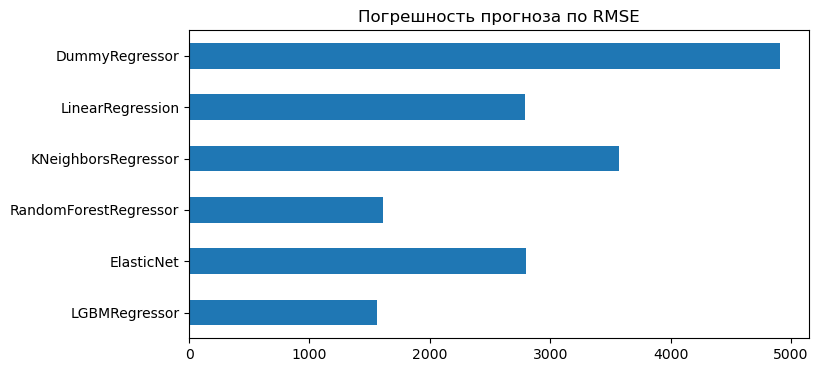

In [62]:
results['Погрешность прогноза по RMSE'].plot(kind='barh', title='Погрешность прогноза по RMSE', figsize=(8,4));

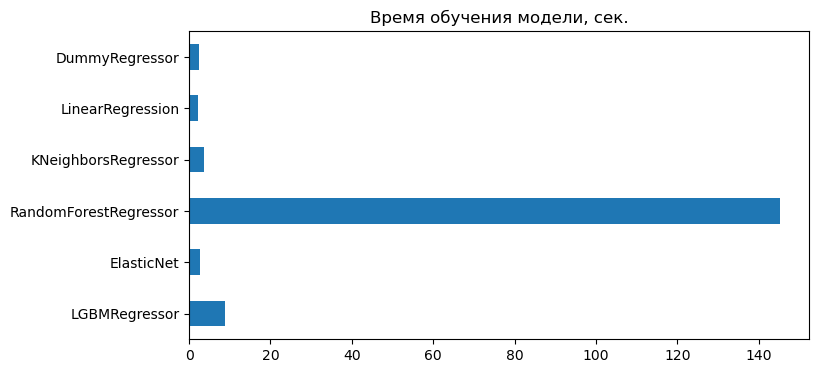

In [57]:
results['Время обучения модели, сек.'].plot(kind='barh', title='Время обучения модели, сек.', figsize=(8,4));

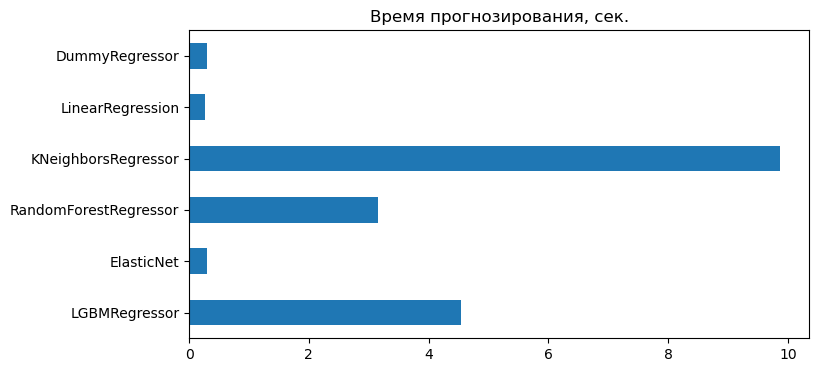

In [58]:
results['Время прогнозирования, сек.'].plot(kind='barh', title='Время прогнозирования, сек.', figsize=(8,4));

### Тестирование модели

Наиболее скоростные алгоритмы, из числа рассмотренных нами, очевидным образом не проходят по качеству точности прогноза, которое было заявлено в техзадании. Единственным алгоритмом одновременно показавшем и хорошую точность и высокие скоростные характеристики предсказуемом стал _LGBMRegressor_. Оценим его точность уже на тестовых данных.

In [59]:
# данные после кодирования и масштабирования
features_train_transformed = preprocessing.fit_transform(features_train, target_train)
features_test_transformed = preprocessing.transform(features_test)
# найденные гиперпараметры модели LGBMRegressor
best_model = LGBMRegressor(colsample_bytree=0.5884359396877478,
                           learning_rate=0.15120957379246172,
                           max_depth=17,
                           min_child_samples=100,
                           n_estimators=238,
                           num_leaves=200,
                           random_state=549,
                           subsample_for_bin=2985).fit(features_train_transformed, target_train)
# результаты оценки модели тестовых данных
predictions = best_model.predict(features_test_transformed)                               
score = mean_squared_error(target_test, predictions) ** .5
print('Точность прогноза на тестовых данных для LGBMRegressor по RMSE равна %.2f' %(score)) 

Точность прогноза на тестовых данных для LGBMRegressor по RMSE равна 1552.25


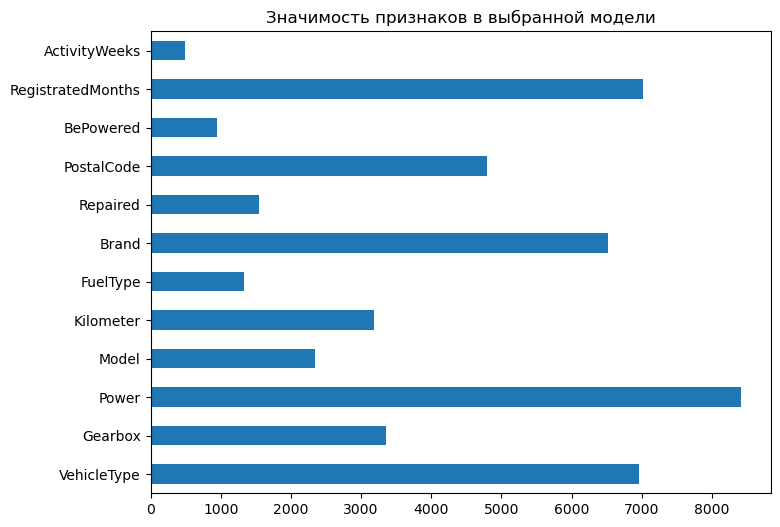

In [60]:
# диаграмма значимости признаков
fi = pd.Series(best_model.feature_importances_, index=features_train.columns)
fi.plot.barh(title='Значимость признаков в выбранной модели', figsize=(8,6));

## Общие выводы

__Заключение по проделанной работе:__  

При работе над проектом начальные данные подверглись значительной коррекции. В категориальных признаках обнаружены и заполнены многочисленные пропуски. Часть неинформативных признаков была удалена. Были созданы новые признаки, учитывающие некоторые временные параметры.  
Чтобы избежать увеличения признакового пространства после _one-hot_-кодирования категориальных признаков с большим количеством уникальных значений, были предложены рациональные альтернативы этому. Был использован кодировщик типа _Target-based Coding_ из библиотеки _Category Encoders_.  
Для подбора гиперпараметров использовалась библиотека оптимизации _Optuna_. Для оценки качества моделей написана функция записи необходимых характеристик.

__Вывод по результатам проекта:__  

При выборе модели машинного обучения для проекта должны были учитываться не только качество прогнозов, но также скорости обучения модели и получения прогнозов с помощью неё. Поэтому рассматривались несколько типов алгоритмов и наиболее быстрые - линейная регрессия и близкая ей `ElasticNet`  - показали хорошие характеристики по производительности и среднее качество прогноза (базовый уровень точности определялся прогнозами `DummyRegressor`). Другую группу составили алгоритмы, основанные на решающих деревьях - `RandomForestRegressor` и `LGBMRegressor` (только им удалось преодолеть предел минимальной требуемой точности). В первом используется комбинацию бэггинга и метода случайных подпространств над решающими деревьями, второй использует градиентный бустинг.  Модель `RandomForestRegressor` достаточно медленно обучалась, хотя и показала хорошую точность обучения. Особенно это было заметно при первоначальном унитарном кодировании категориальных признаков - из-за него число признаков увеличилось до нескольких тысяч. Стоит отметить, что _one-hot_- кодированиt (и схожие с ним алгоритмы типа _Contrast Coding_) хотя и не слишком рациональный выбор для данного проекта, но в общем случае даёт наилучшее качество прогноза. Новый вариант целевого кодирования сказался на линейных моделях - их качество упало. При этом `LGBMRegressor` отлично справился с обеими ситуациями, показав и хорошее качество прогноза и достойную скорость обучения. По скорости обучения он, разумеется, уступает таким быстрым алгоритмам как `ElasticNet`. Однако, по субъективным ощущениям с точки зрения пользователя он очень быстр, так что его можно смело рекомендовать в качестве основной модели машинного обучения в данном проекте.